In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [2]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [3]:
# other dependencies
#!pip install timm ipywidgets

In [4]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [5]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [6]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [7]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [8]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob

In [9]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [10]:
#Global Training variables 
num_workers=4
pin_memory=True
#train_size = 100
batch_size = 128
test_batch_size = 128
DEBUG = False
num_epochs = 100

### Run all these function definition cells
These have been extracted from the lib folder and are here to make them more easily editable.  Most of the action happens in *get_feat_torch*, which does feature extraction and *train_model*

In [11]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [12]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' , 'others']
classes_no_other = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]
other_ind = classes.index('others')

### Read CSV and get train/test groups

In [13]:
if DEBUG:
    df = pd.read_csv(config.data_df_msc_test)
else:
    df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [14]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"

    

In [15]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes_no_other:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [16]:
len(df)

6008

In [17]:
USE_SHORT_AUDIO = True

In [18]:
#Test should happen on Cup and Tanzania
idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_tz_cup = df[idx_multiclass]

In [19]:
df_tz_cup.reset_index(inplace = True)
df_tz_cup.drop('index',axis = 1)
df.reset_index(inplace = True)
df.drop('index',axis = 1)

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6004,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6005,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6006,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8


In [20]:
#https://stackoverflow.com/questions/18180763/set-difference-for-pandas
df_temp = pd.concat([df, df_tz_cup, df_tz_cup]).drop_duplicates(keep=False)

### Verifying that the temp data does not have any test leakage

In [21]:
#np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_temp[(np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup'))].sum()
#df_temp([df_temp['country'] == 'Tanzania' and df_temp['location_type'] == 'cup'])

/tmp/ipykernel_2865276/2543128270.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_temp[(np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup'))].sum()


index              0.0
id                 0.0
length             0.0
name               0.0
sample_rate        0.0
record_datetime    0.0
sound_type         0.0
species            0.0
gender             0.0
fed                0.0
plurality          0.0
age                0.0
method             0.0
mic_type           0.0
device_type        0.0
country            0.0
district           0.0
province           0.0
place              0.0
location_type      0.0
specie_ind         0.0
dtype: float64

In [22]:
df_temp.reset_index(inplace = True)
df_temp.drop('index',axis = 1,inplace = True)
df_temp.drop('level_0',axis = 1,inplace = True)

In [23]:
df_temp

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
3455,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
3456,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
3457,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8


In [24]:
print("len of df_temp = " + str(len(df_temp)))
print("len of df_tz_cup = " + str(len(df_tz_cup)))
print("len of df = " + str(len(df)))
if (len(df) == len(df_tz_cup) + len(df_temp)):
    print("split successful")
else:
    print("split error")

len of df_temp = 3459
len of df_tz_cup = 2549
len of df = 6008
split successful


### Before we start training we need to also have some samples from tz_cup in training

In [25]:
df_tz_cup_samp = df_tz_cup.sample(frac = .8 , random_state = 42)
print("length of df_tz_cup_samp = " + str(len(df_tz_cup_samp)))

length of df_tz_cup_samp = 2039


In [26]:
df_test = pd.concat([df_tz_cup, df_tz_cup_samp, df_tz_cup_samp]).drop_duplicates(keep=False)

In [27]:
len(df_test)

510

Add some TZ_cup sampled to the Training data

In [28]:
temp_train_frame = [df_temp , df_tz_cup_samp]
df_temp_train = pd.concat(temp_train_frame)
print("length of concatenated frame = " + str(len(df_temp_train)))

length of concatenated frame = 5498


### Finally a train-val split

In [29]:
from sklearn.model_selection import train_test_split

#df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
df_train,df_val  = train_test_split(df_temp_train, test_size=0.2 , random_state= 42)

In [30]:
print("length of train = " + str(len(df_train)))
print("length of val = " + str(len(df_val)))


length of train = 4398
length of val = 1100


In [31]:
df_train_offset = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
df_test_offset = get_offsets_df(df_test, short_audio=USE_SHORT_AUDIO)
df_val_offset = get_offsets_df(df_val, short_audio=USE_SHORT_AUDIO)

In [32]:
print("length of train offset = " +str(len(df_train_offset)))
print("length of test offset = " +str(len(df_test_offset)))
print("length of val offset = " +str(len(df_val_offset)))

length of train offset = 104000
length of test offset = 23294
length of val offset = 24518


In [33]:
# from sklearn.model_selection import train_test_split

# df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
# df_train_offset,df_val_offset  = train_test_split(df_train_offset_temp, test_size=0.2)


In [34]:
# for i in range(0,len(classes)):
#     df_temp = df_val_offset[df_val_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))

In [35]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



In [36]:
def get_specie_distri(df , classes , type_df = None):
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [37]:
#class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_CNN)),y=np.array(y_train_CNN))
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.3844931  0.80723406 4.37048243 0.81245557 3.46078333 5.12214342
 3.94118539 9.71055089 0.34967033]


In [38]:
len(df_val_offset)

24518

In [39]:
#get_specie_distri(df_train_offset , classes , type_df = "train")
#get_specie_distri(df_val_offset , classes , type_df = "Val")
get_specie_distri(df_test_offset , classes , type_df = "test")

DF type = test
i = 0
9018
DF type = test
i = 1
4157
DF type = test
i = 2
429
DF type = test
i = 3
3422
DF type = test
i = 4
1327
DF type = test
i = 5
657
DF type = test
i = 6
975
DF type = test
i = 7
423
DF type = test
i = 8
2886


In [40]:
### get the frame offsets for each audio file into dataframes
# audio_df_train = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
# audio_df_test_A = get_offsets_df(df_test_A, short_audio=False)
# audio_df_test_B = get_offsets_df(df_test_B, short_audio=False)

In [41]:
# This function pads a file with 0s to make it a 1.92 sec file
def pad_zero(x_temp,rate = config.rate, min_length = config.min_duration ):
    #print("inside padding zero...")
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    #print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [42]:
def load_model(filepath, model):
    # Instantiate model to inspect
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

In [43]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(0,9))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [44]:
def concat_df(df_offset, indices):
    list_df_ind = []
    #print("len of indices = " + str(len(indices)))
    for ind in indices :
        df_name = "df_"+ str(ind)
        df_name = df_offset[df_offset['specie_ind'] == ind]
        list_df_ind.append(df_name)
    df_offset_trimmed = pd.concat(list_df_ind)
    return(df_offset_trimmed)

In [45]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### Class Defintions

In [46]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [47]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [48]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,0,222214,0,10.24,8
1,1,222214,2561,10.24,8
2,2,222214,5121,10.24,8
3,3,222214,7681,10.24,8
4,4,222214,10241,10.24,8


In [49]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred

In [50]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(tk0):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 200 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            y = inputs[1].type(torch.LongTensor).to(device)
            global_step += 1
            optimiser.zero_grad()
            # AMP
            with autocast():
                y_pred = model(x)['prediction']
                preds = torch.argmax(y_pred, axis = 1)
                if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                loss = criterion(y_pred, y)
            loss_scaler(loss, optimiser,parameters=model_parameters(model))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            lr_log.append(optimiser.param_groups[0]['lr'])
            tk0.set_postfix(training_loss=(train_loss / (batch_i+1)), lr=optimiser.param_groups[0]['lr'])
            del x
            del y
            del y_pred,preds
        
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        if DEBUG:
            print("train_f1 = " +str(train_f1))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        if DEBUG:
            print("val accuracy = " + str(val_f1))
        all_val_loss.append(val_loss)
        all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        if acc_metric > best_acc_metric:  
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
            print("Now printing classification rport... ")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_acc = val_f1
            best_val_loss = val_loss
            overrun_counter = -1
        overrun_counter += 1
        print('Epoch: %d, Train Loss: %.8f, Train F1: %.8f, Val Loss: %.8f, Val F1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log

In [51]:
class MozDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_zero(waveform)
        else:
            f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [52]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=9, in_chans=1, 
                        drop_path_rate=0.05, global_pool='max',
                        drop_rate=0.05)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                          fmin=400, fmax=2000, sr=config.rate, output_format="Magnitude", trainable=True,)
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
        spec = self.timeMasking(spec)
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [53]:
# test = torch.rand(1,15360)

# model =Model('convnext_small',224)
# op = model(test)
# print(op)

In [54]:
#https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264
# from torch.utils.data.sampler import WeightedRandomSampler
# class_sample_count = []
# for i in range(0,len(classes)):
#     df_temp = df_train_offset[df_train_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))
#     class_sample_count.append(len(df_temp))
# print("class_sample_count = " + str(class_sample_count))
# class_sample_count_arr = np.array(class_sample_count)
# weight = 1. / class_sample_count_arr
# print("weight = " +str(weight))
# samples_weight = []
# for t in range(len(classes)):
#     samples_weight.append(weight[t])
    
# samples_weight = np.array(samples_weight)
# print("samples_weight = " +str(samples_weight))

# samples_weight = torch.from_numpy(samples_weight)
# samples_weigth = samples_weight.double()
# sampler = WeightedRandomSampler(samples_weight, len(classes)*10000)
  
# class_sample_count = np.array( [len(np.where(target == t)[0]) for t in np.unique(target)])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])


In [55]:
df_train_offset

,index,id,offset,length,specie_ind
0,0,222214,0,10.24000,8
1,1,222214,2561,10.24000,8
2,2,222214,5121,10.24000,8
3,3,222214,7681,10.24000,8
4,4,222214,10241,10.24000,8
...,...,...,...,...,...
103995,103995,1130,43521,9.20562,8
103996,103996,1130,46081,9.20562,8
103997,103997,1130,48641,9.20562,8
103998,103998,1130,51201,9.20562,8


In [56]:
train_dataset = MozDataset(df_train_offset,  config.data_dir, min_length)
val_dataset = MozDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


In [57]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 104000
Length of train loader = 813


In [58]:
# test_iter = iter(val_loader)
# a,b = test_iter.next()
# print(a.shape)
# print(b)

In [59]:
# Test block

#temp_ten = torch.rand(64, 9, 1, 15360)
# temp_ten.shape
# bat_len = temp_ten.shape[0]
# print("bat_len = " +str(bat_len))
# for i in range (bat_len):
#     print("i = " + str(i))
#     elem = temp_ten[i,:,:,:]
#     print("elem shape = " +str(elem.shape))
#     for j in range(elem.shape[0]):
#         img = elem[j,:,:]
#         print("img shape = " +str(img.shape))
        

## Training

In [60]:
len(df_train_offset)

104000

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0802 seconds
Training on cuda:0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 0batch = 0 of 813duraation = 0.08816061019897461
epoch = 0batch = 200 of 813duraation = 4.9633068879445394
epoch = 0batch = 400 of 813duraation = 9.823055982589722
epoch = 0batch = 600 of 813duraation = 14.704402112960816
epoch = 0batch = 800 of 813duraation = 20.421729473272958
Saving model to: ../outputs/models/pytorch/model_e0_2022_09_16_11_14_27.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.65      0.38      0.48      9018
culex pipiens complex       0.46      0.35      0.40      4157
           ae aegypti       0.05      0.50      0.10       429
       an funestus ss       0.39      0.54      0.45      3422
         an squamosus       0.15      0.18      0.16      1327
          an coustani       0.27      0.45      0.33       657
         ma uniformis       0.15      0.17      0.16       975
         ma africanus       0.08      0.28      0.12       423
               others       0.

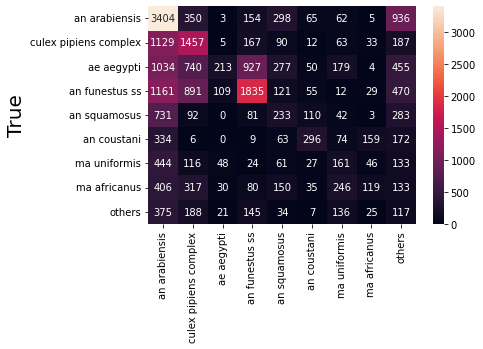

Epoch: 0, Train Loss: 1.68709750, Train F1: 0.41150943, Val Loss: 0.00713286, Val F1: 0.56353157, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 1batch = 0 of 813duraation = 0.09699256420135498
epoch = 1batch = 200 of 813duraation = 5.186384121576945
epoch = 1batch = 400 of 813duraation = 10.347831682364147
epoch = 1batch = 600 of 813duraation = 15.225890187422435
epoch = 1batch = 800 of 813duraation = 20.16967128912608
Saving model to: ../outputs/models/pytorch/model_e1_2022_09_16_11_45_39.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.69      0.40      0.51      9018
culex pipiens complex       0.42      0.50      0.45      4157
           ae aegypti       0.15      0.48      0.22       429
       an funestus ss       0.48      0.59      0.53      3422
         an squamosus       0.16      0.42      0.23      1327
          an coustani       0.26      0.47      0.33       657
         ma uniformis       0.14      0.19      0.16       975
         ma africanus       0.09      0.16      0.11       423
               others       0.2

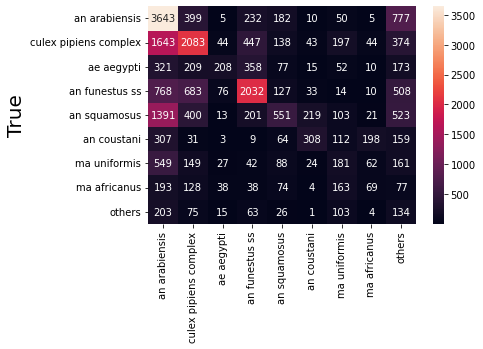

Epoch: 1, Train Loss: 1.02583086, Train F1: 0.62513069, Val Loss: 0.00634800, Val F1: 0.61397048, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 2batch = 0 of 813duraation = 0.10682140986124675
epoch = 2batch = 200 of 813duraation = 5.102137096722921
epoch = 2batch = 400 of 813duraation = 10.383068831761678
epoch = 2batch = 600 of 813duraation = 15.372433912754058
epoch = 2batch = 800 of 813duraation = 20.220931414763132
Saving model to: ../outputs/models/pytorch/model_e2_2022_09_16_12_16_13.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.67      0.39      0.49      9018
culex pipiens complex       0.54      0.46      0.50      4157
           ae aegypti       0.12      0.49      0.19       429
       an funestus ss       0.48      0.61      0.54      3422
         an squamosus       0.18      0.37      0.24      1327
          an coustani       0.17      0.48      0.25       657
         ma uniformis       0.21      0.33      0.25       975
         ma africanus       0.11      0.10      0.11       423
               others       0.

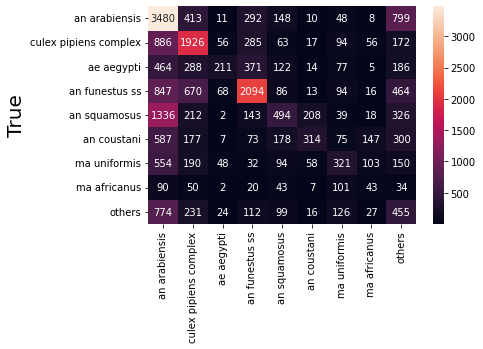

Epoch: 2, Train Loss: 0.75446516, Train F1: 0.69582071, Val Loss: 0.00643209, Val F1: 0.61543495, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 3batch = 0 of 813duraation = 0.08604828914006551
epoch = 3batch = 200 of 813duraation = 4.993786938985189
epoch = 3batch = 400 of 813duraation = 10.202367035547892
epoch = 3batch = 600 of 813duraation = 15.230606857935587
epoch = 3batch = 800 of 813duraation = 20.1154043952624
Saving model to: ../outputs/models/pytorch/model_e3_2022_09_16_12_47_42.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.67      0.43      0.52      9018
culex pipiens complex       0.42      0.55      0.47      4157
           ae aegypti       0.17      0.26      0.20       429
       an funestus ss       0.53      0.56      0.54      3422
         an squamosus       0.18      0.47      0.26      1327
          an coustani       0.27      0.39      0.32       657
         ma uniformis       0.18      0.30      0.23       975
         ma africanus       0.07      0.17      0.10       423
               others       0.30

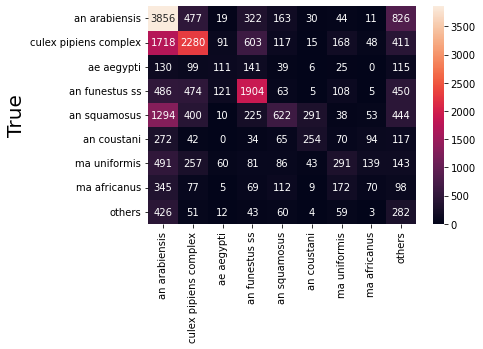

Epoch: 3, Train Loss: 0.58838006, Train F1: 0.74597056, Val Loss: 0.00632519, Val F1: 0.63891782, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 4batch = 0 of 813duraation = 0.08501058022181193
epoch = 4batch = 200 of 813duraation = 5.025755484898885
epoch = 4batch = 400 of 813duraation = 10.206531369686127
epoch = 4batch = 600 of 813duraation = 15.177142123381296
epoch = 4batch = 800 of 813duraation = 20.047642970085143
Saving model to: ../outputs/models/pytorch/model_e4_2022_09_16_13_18_52.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.69      0.43      0.53      9018
culex pipiens complex       0.44      0.52      0.48      4157
           ae aegypti       0.11      0.25      0.15       429
       an funestus ss       0.47      0.64      0.54      3422
         an squamosus       0.17      0.42      0.24      1327
          an coustani       0.20      0.48      0.28       657
         ma uniformis       0.27      0.25      0.26       975
         ma africanus       0.09      0.08      0.09       423
               others       0.

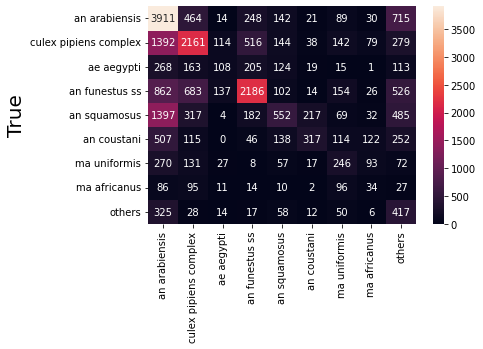

Epoch: 4, Train Loss: 0.47057502, Train F1: 0.78912896, Val Loss: 0.00626170, Val F1: 0.65287809, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 5batch = 0 of 813duraation = 0.0885015328725179
epoch = 5batch = 200 of 813duraation = 4.997588781515757
epoch = 5batch = 400 of 813duraation = 10.15351795355479
epoch = 5batch = 600 of 813duraation = 15.166740949948629
epoch = 5batch = 800 of 813duraation = 20.074722162882487
Saving model to: ../outputs/models/pytorch/model_e5_2022_09_16_13_49_56.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.69      0.53      0.60      9018
culex pipiens complex       0.51      0.51      0.51      4157
           ae aegypti       0.13      0.28      0.18       429
       an funestus ss       0.47      0.66      0.55      3422
         an squamosus       0.22      0.34      0.27      1327
          an coustani       0.19      0.50      0.27       657
         ma uniformis       0.25      0.29      0.27       975
         ma africanus       0.13      0.16      0.15       423
               others       0.46

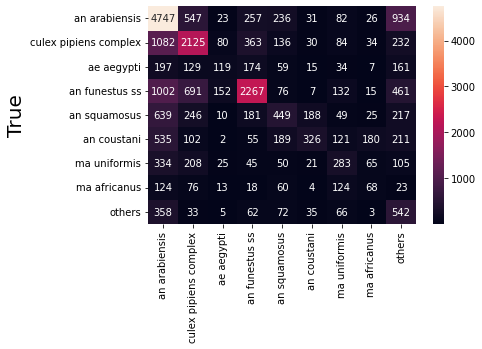

Epoch: 5, Train Loss: 0.38260498, Train F1: 0.82393592, Val Loss: 0.00659178, Val F1: 0.66379915, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 6batch = 0 of 813duraation = 0.08801845709482829
epoch = 6batch = 200 of 813duraation = 5.015119898319244
epoch = 6batch = 400 of 813duraation = 10.176560707887013
epoch = 6batch = 600 of 813duraation = 15.195958415667215
epoch = 6batch = 800 of 813duraation = 20.125614472230275
Saving model to: ../outputs/models/pytorch/model_e6_2022_09_16_14_21_33.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.64      0.57      0.60      9018
culex pipiens complex       0.49      0.52      0.50      4157
           ae aegypti       0.15      0.36      0.21       429
       an funestus ss       0.55      0.53      0.54      3422
         an squamosus       0.23      0.35      0.28      1327
          an coustani       0.22      0.49      0.30       657
         ma uniformis       0.22      0.26      0.24       975
         ma africanus       0.11      0.16      0.13       423
               others       0.

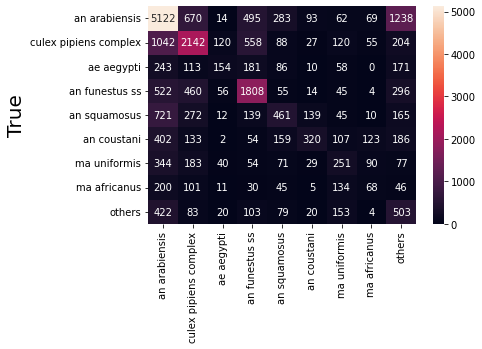

Epoch: 6, Train Loss: 0.33351593, Train F1: 0.84733635, Val Loss: 0.00657892, Val F1: 0.66865742, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 7batch = 0 of 813duraation = 0.08972518841425578
epoch = 7batch = 200 of 813duraation = 5.023716191450755
epoch = 7batch = 400 of 813duraation = 10.335892681280772
epoch = 7batch = 600 of 813duraation = 15.28805965979894
epoch = 7batch = 800 of 813duraation = 20.428194665908812
Saving model to: ../outputs/models/pytorch/model_e7_2022_09_16_14_53_25.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.64      0.57      0.60      9018
culex pipiens complex       0.47      0.47      0.47      4157
           ae aegypti       0.11      0.35      0.17       429
       an funestus ss       0.46      0.68      0.55      3422
         an squamosus       0.25      0.25      0.25      1327
          an coustani       0.26      0.43      0.32       657
         ma uniformis       0.28      0.34      0.31       975
         ma africanus       0.15      0.09      0.12       423
               others       0.3

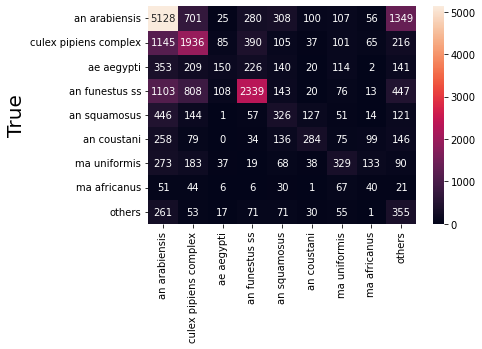

Epoch: 7, Train Loss: 0.29027387, Train F1: 0.86806447, Val Loss: 0.00629265, Val F1: 0.68743903, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 8batch = 0 of 813duraation = 0.10909340381622315
epoch = 8batch = 200 of 813duraation = 5.122807669639587
epoch = 8batch = 400 of 813duraation = 10.53900905052821
epoch = 8batch = 600 of 813duraation = 15.524336795012156
epoch = 8batch = 800 of 813duraation = 20.63255302111308
Saving model to: ../outputs/models/pytorch/model_e8_2022_09_16_15_25_49.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.63      0.57      0.60      9018
culex pipiens complex       0.49      0.46      0.48      4157
           ae aegypti       0.08      0.26      0.12       429
       an funestus ss       0.49      0.64      0.56      3422
         an squamosus       0.25      0.23      0.24      1327
          an coustani       0.22      0.56      0.31       657
         ma uniformis       0.36      0.10      0.15       975
         ma africanus       0.15      0.14      0.15       423
               others       0.27

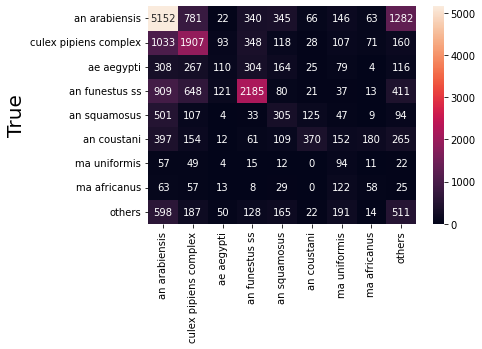

Epoch: 8, Train Loss: 0.24252680, Train F1: 0.88829764, Val Loss: 0.00727596, Val F1: 0.66937911, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 9batch = 0 of 813duraation = 0.11188135941823324
epoch = 9batch = 200 of 813duraation = 5.235354336102803
epoch = 9batch = 400 of 813duraation = 10.518060727914174
epoch = 9batch = 600 of 813duraation = 15.506158578395844
epoch = 9batch = 800 of 813duraation = 20.3799467364947
Saving model to: ../outputs/models/pytorch/model_e9_2022_09_16_15_57_13.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.68      0.48      0.56      9018
culex pipiens complex       0.47      0.51      0.49      4157
           ae aegypti       0.18      0.24      0.21       429
       an funestus ss       0.48      0.69      0.57      3422
         an squamosus       0.22      0.40      0.28      1327
          an coustani       0.19      0.40      0.26       657
         ma uniformis       0.35      0.31      0.33       975
         ma africanus       0.08      0.03      0.04       423
               others       0.36

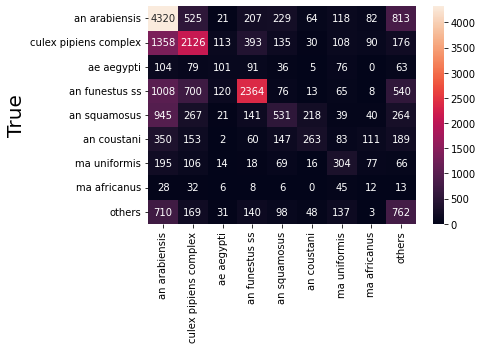

Epoch: 9, Train Loss: 0.21232917, Train F1: 0.90033426, Val Loss: 0.00740653, Val F1: 0.66030078, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 10batch = 0 of 813duraation = 0.09559346437454223
epoch = 10batch = 200 of 813duraation = 4.947344398498535
epoch = 10batch = 400 of 813duraation = 9.856667033831279
epoch = 10batch = 600 of 813duraation = 14.778613690535227
epoch = 10batch = 800 of 813duraation = 19.634343433380128
Saving model to: ../outputs/models/pytorch/model_e10_2022_09_16_16_26_50.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.58      0.70      0.64      9018
culex pipiens complex       0.48      0.54      0.51      4157
           ae aegypti       0.16      0.22      0.19       429
       an funestus ss       0.51      0.54      0.52      3422
         an squamosus       0.26      0.19      0.22      1327
          an coustani       0.28      0.38      0.33       657
         ma uniformis       0.40      0.15      0.22       975
         ma africanus       0.21      0.10      0.13       423
               others    

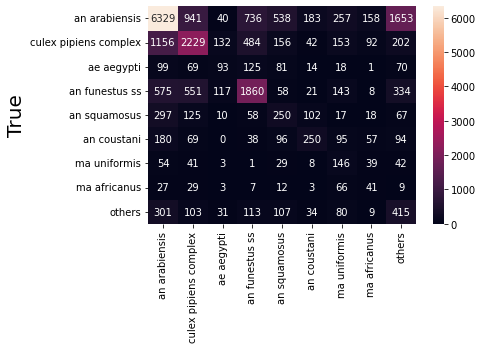

Epoch: 10, Train Loss: 0.19929185, Train F1: 0.90869358, Val Loss: 0.00667262, Val F1: 0.69843216, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 11batch = 0 of 813duraation = 0.08819975852966308
epoch = 11batch = 200 of 813duraation = 5.0901971141497295
epoch = 11batch = 400 of 813duraation = 10.15846730073293
epoch = 11batch = 600 of 813duraation = 15.141459941864014
epoch = 11batch = 800 of 813duraation = 20.05752114057541
Saving model to: ../outputs/models/pytorch/model_e11_2022_09_16_16_57_28.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.64      0.64      0.64      9018
culex pipiens complex       0.49      0.48      0.49      4157
           ae aegypti       0.14      0.19      0.16       429
       an funestus ss       0.47      0.66      0.55      3422
         an squamosus       0.26      0.20      0.23      1327
          an coustani       0.25      0.40      0.31       657
         ma uniformis       0.32      0.33      0.32       975
         ma africanus       0.16      0.13      0.15       423
               others    

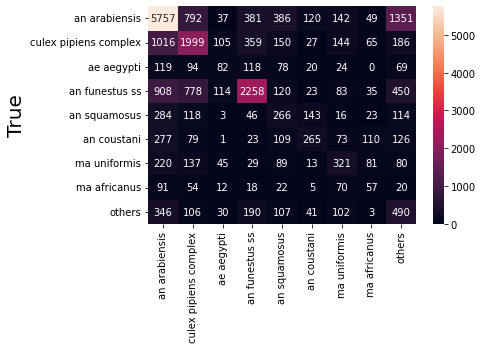

Epoch: 11, Train Loss: 0.18434660, Train F1: 0.91694561, Val Loss: 0.00703501, Val F1: 0.69244241, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 12batch = 0 of 813duraation = 0.11437052885691325
epoch = 12batch = 200 of 813duraation = 5.027663926283519
epoch = 12batch = 400 of 813duraation = 10.212838705380758
epoch = 12batch = 600 of 813duraation = 15.196911974747975
epoch = 12batch = 800 of 813duraation = 20.113577032089232
Saving model to: ../outputs/models/pytorch/model_e12_2022_09_16_17_28_39.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.66      0.57      0.61      9018
culex pipiens complex       0.48      0.52      0.50      4157
           ae aegypti       0.14      0.21      0.17       429
       an funestus ss       0.47      0.72      0.57      3422
         an squamosus       0.29      0.21      0.25      1327
          an coustani       0.22      0.42      0.29       657
         ma uniformis       0.35      0.21      0.26       975
         ma africanus       0.17      0.09      0.12       423
               others   

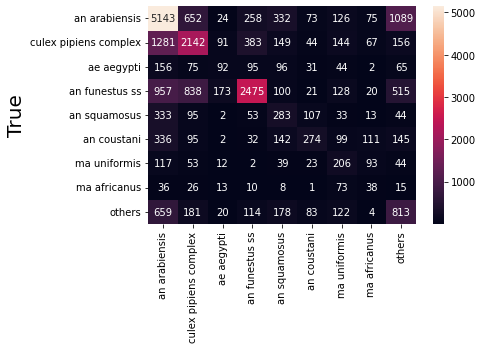

Epoch: 12, Train Loss: 0.17192368, Train F1: 0.92370672, Val Loss: 0.00708236, Val F1: 0.68400351, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 13batch = 0 of 813duraation = 0.10245312849680582
epoch = 13batch = 200 of 813duraation = 5.046433146794637
epoch = 13batch = 400 of 813duraation = 10.32318698167801
epoch = 13batch = 600 of 813duraation = 15.30878955523173
epoch = 13batch = 800 of 813duraation = 20.210854466756185
Saving model to: ../outputs/models/pytorch/model_e13_2022_09_16_17_59_40.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.64      0.56      0.60      9018
culex pipiens complex       0.45      0.55      0.50      4157
           ae aegypti       0.17      0.22      0.19       429
       an funestus ss       0.47      0.65      0.55      3422
         an squamosus       0.23      0.22      0.23      1327
          an coustani       0.29      0.33      0.31       657
         ma uniformis       0.35      0.25      0.29       975
         ma africanus       0.12      0.11      0.11       423
               others     

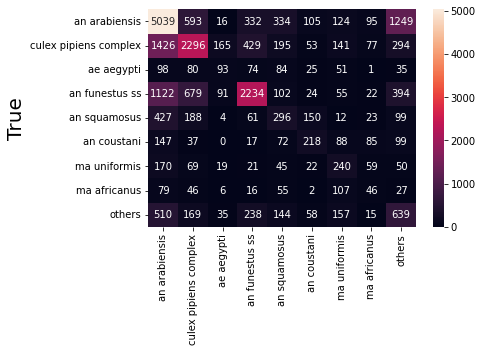

Epoch: 13, Train Loss: 0.15384332, Train F1: 0.93097336, Val Loss: 0.00722682, Val F1: 0.67905187, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 14batch = 0 of 813duraation = 0.09900779326756795
epoch = 14batch = 200 of 813duraation = 5.008213249842326
epoch = 14batch = 400 of 813duraation = 10.157252220312754
epoch = 14batch = 600 of 813duraation = 15.16975413163503
epoch = 14batch = 800 of 813duraation = 20.350543630123138
Saving model to: ../outputs/models/pytorch/model_e14_2022_09_16_18_30_55.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.63      0.60      0.61      9018
culex pipiens complex       0.42      0.60      0.50      4157
           ae aegypti       0.14      0.18      0.16       429
       an funestus ss       0.50      0.56      0.53      3422
         an squamosus       0.25      0.25      0.25      1327
          an coustani       0.25      0.36      0.29       657
         ma uniformis       0.38      0.14      0.21       975
         ma africanus       0.06      0.05      0.06       423
               others    

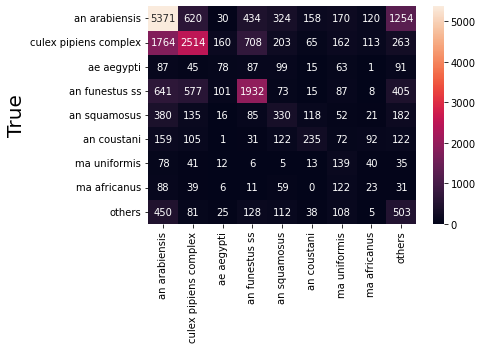

Epoch: 14, Train Loss: 0.15367889, Train F1: 0.93316740, Val Loss: 0.00755173, Val F1: 0.68289545, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 15batch = 0 of 813duraation = 0.11082966725031534
epoch = 15batch = 200 of 813duraation = 5.19071462949117
epoch = 15batch = 400 of 813duraation = 10.285895399252574
epoch = 15batch = 600 of 813duraation = 15.23185627857844
epoch = 15batch = 800 of 813duraation = 20.144755816459657
Saving model to: ../outputs/models/pytorch/model_e15_2022_09_16_19_02_17.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.64      0.63      0.64      9018
culex pipiens complex       0.54      0.45      0.49      4157
           ae aegypti       0.19      0.27      0.23       429
       an funestus ss       0.48      0.69      0.56      3422
         an squamosus       0.25      0.22      0.24      1327
          an coustani       0.30      0.42      0.35       657
         ma uniformis       0.28      0.34      0.31       975
         ma africanus       0.08      0.04      0.05       423
               others     

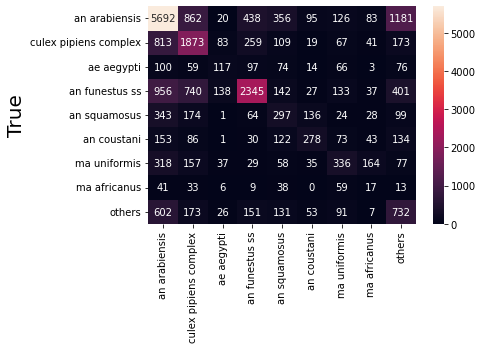

Epoch: 15, Train Loss: 0.13164916, Train F1: 0.94188041, Val Loss: 0.00763523, Val F1: 0.68274899, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 16batch = 0 of 813duraation = 0.0888360857963562
epoch = 16batch = 200 of 813duraation = 4.967558352152507
epoch = 16batch = 400 of 813duraation = 9.974291026592255
epoch = 16batch = 600 of 813duraation = 15.041398549079895
epoch = 16batch = 800 of 813duraation = 19.98441816965739
Saving model to: ../outputs/models/pytorch/model_e16_2022_09_16_19_32_32.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.60      0.61      9018
culex pipiens complex       0.45      0.55      0.50      4157
           ae aegypti       0.25      0.35      0.29       429
       an funestus ss       0.55      0.55      0.55      3422
         an squamosus       0.24      0.28      0.25      1327
          an coustani       0.21      0.43      0.28       657
         ma uniformis       0.29      0.20      0.24       975
         ma africanus       0.07      0.04      0.05       423
               others      

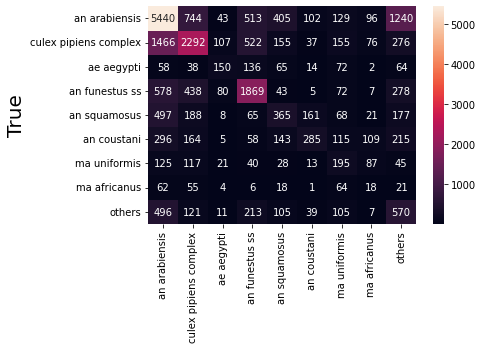

Epoch: 16, Train Loss: 0.11957148, Train F1: 0.94741193, Val Loss: 0.00798924, Val F1: 0.67662857, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 17batch = 0 of 813duraation = 0.09357006152470906
epoch = 17batch = 200 of 813duraation = 4.988591436545054
epoch = 17batch = 400 of 813duraation = 9.976634955406189
epoch = 17batch = 600 of 813duraation = 14.908932026227316
epoch = 17batch = 800 of 813duraation = 19.80579628944397
Saving model to: ../outputs/models/pytorch/model_e17_2022_09_16_20_02_24.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.63      0.63      0.63      9018
culex pipiens complex       0.49      0.49      0.49      4157
           ae aegypti       0.15      0.31      0.21       429
       an funestus ss       0.53      0.57      0.55      3422
         an squamosus       0.25      0.24      0.24      1327
          an coustani       0.26      0.45      0.33       657
         ma uniformis       0.28      0.37      0.32       975
         ma africanus       0.05      0.03      0.04       423
               others     

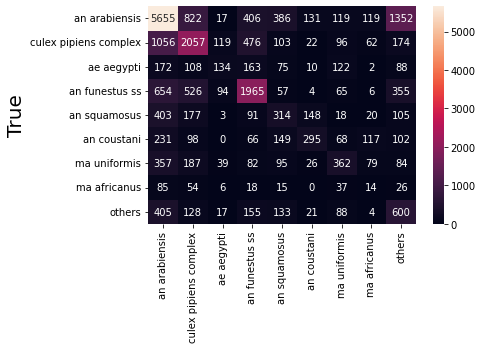

Epoch: 17, Train Loss: 0.12382356, Train F1: 0.94580201, Val Loss: 0.00832137, Val F1: 0.68906295, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 18batch = 0 of 813duraation = 0.0972034494082133
epoch = 18batch = 200 of 813duraation = 5.011691355705262
epoch = 18batch = 400 of 813duraation = 10.22505408525467
epoch = 18batch = 600 of 813duraation = 15.25894695520401
epoch = 18batch = 800 of 813duraation = 20.239684307575224
Saving model to: ../outputs/models/pytorch/model_e18_2022_09_16_20_33_07.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.64      0.61      0.62      9018
culex pipiens complex       0.50      0.49      0.50      4157
           ae aegypti       0.10      0.21      0.14       429
       an funestus ss       0.49      0.66      0.56      3422
         an squamosus       0.24      0.23      0.24      1327
          an coustani       0.30      0.42      0.35       657
         ma uniformis       0.31      0.31      0.31       975
         ma africanus       0.11      0.17      0.14       423
               others      

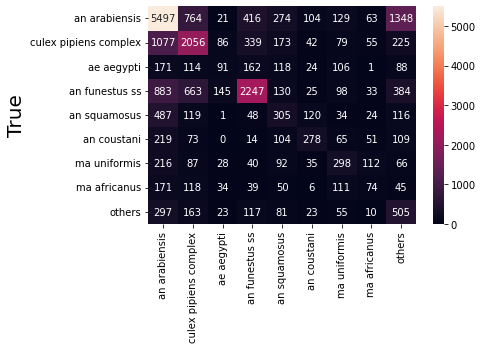

Epoch: 18, Train Loss: 0.13369819, Train F1: 0.94302628, Val Loss: 0.00794748, Val F1: 0.67993463, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 19batch = 0 of 813duraation = 0.09734838406244914
epoch = 19batch = 200 of 813duraation = 5.0920230348904925
epoch = 19batch = 400 of 813duraation = 10.180002760887145
epoch = 19batch = 600 of 813duraation = 15.102103972434998
epoch = 19batch = 800 of 813duraation = 20.00888543923696
Saving model to: ../outputs/models/pytorch/model_e19_2022_09_16_21_03_54.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.64      0.63      9018
culex pipiens complex       0.49      0.51      0.50      4157
           ae aegypti       0.17      0.31      0.22       429
       an funestus ss       0.54      0.53      0.54      3422
         an squamosus       0.19      0.31      0.23      1327
          an coustani       0.29      0.36      0.32       657
         ma uniformis       0.31      0.27      0.29       975
         ma africanus       0.11      0.06      0.08       423
               others   

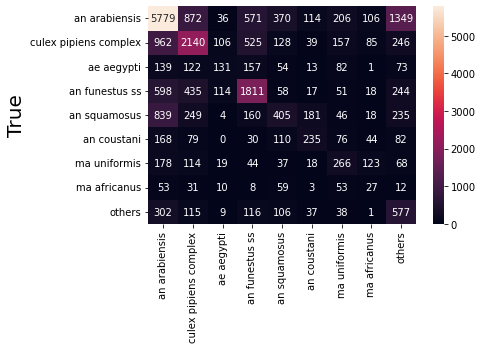

Epoch: 19, Train Loss: 0.10631385, Train F1: 0.95438289, Val Loss: 0.00873344, Val F1: 0.67891766, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 20batch = 0 of 813duraation = 0.08740005493164063
epoch = 20batch = 200 of 813duraation = 4.936841936906179
epoch = 20batch = 400 of 813duraation = 10.252316037813822
epoch = 20batch = 600 of 813duraation = 15.295346240202585
epoch = 20batch = 800 of 813duraation = 20.23199460109075
Saving model to: ../outputs/models/pytorch/model_e20_2022_09_16_21_34_55.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.65      0.52      0.58      9018
culex pipiens complex       0.46      0.58      0.51      4157
           ae aegypti       0.13      0.14      0.13       429
       an funestus ss       0.49      0.67      0.56      3422
         an squamosus       0.21      0.31      0.25      1327
          an coustani       0.24      0.45      0.31       657
         ma uniformis       0.36      0.22      0.28       975
         ma africanus       0.14      0.08      0.10       423
               others    

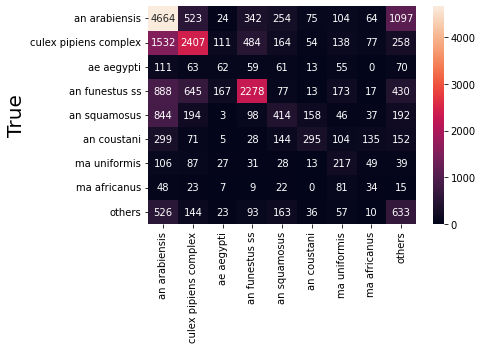

Epoch: 20, Train Loss: 0.10131614, Train F1: 0.95649009, Val Loss: 0.00833008, Val F1: 0.67577067, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 21batch = 0 of 813duraation = 0.11277720133463541
epoch = 21batch = 200 of 813duraation = 5.058594989776611
epoch = 21batch = 400 of 813duraation = 10.18809867699941
epoch = 21batch = 600 of 813duraation = 15.112410867214203
epoch = 21batch = 800 of 813duraation = 20.21333605448405
Saving model to: ../outputs/models/pytorch/model_e21_2022_09_16_22_06_27.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.65      0.64      9018
culex pipiens complex       0.50      0.49      0.49      4157
           ae aegypti       0.15      0.24      0.18       429
       an funestus ss       0.51      0.57      0.54      3422
         an squamosus       0.24      0.23      0.23      1327
          an coustani       0.26      0.35      0.30       657
         ma uniformis       0.27      0.27      0.27       975
         ma africanus       0.10      0.09      0.09       423
               others     

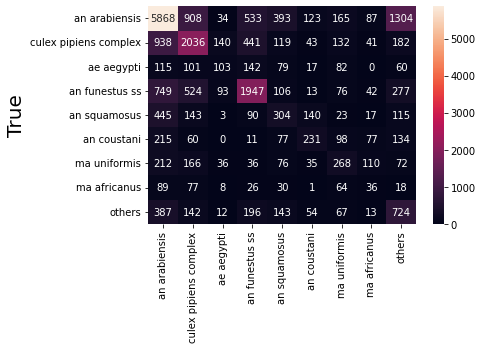

Epoch: 21, Train Loss: 0.10058686, Train F1: 0.95645967, Val Loss: 0.00804239, Val F1: 0.68665192, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 22batch = 0 of 813duraation = 0.11756569544474284
epoch = 22batch = 200 of 813duraation = 5.161047569910685
epoch = 22batch = 400 of 813duraation = 10.39997766415278
epoch = 22batch = 600 of 813duraation = 15.405738008022308
epoch = 22batch = 800 of 813duraation = 20.696123377482095
Saving model to: ../outputs/models/pytorch/model_e22_2022_09_16_22_38_04.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.67      0.64      9018
culex pipiens complex       0.52      0.48      0.50      4157
           ae aegypti       0.10      0.19      0.13       429
       an funestus ss       0.46      0.66      0.54      3422
         an squamosus       0.30      0.24      0.27      1327
          an coustani       0.29      0.35      0.31       657
         ma uniformis       0.37      0.21      0.27       975
         ma africanus       0.10      0.09      0.10       423
               others    

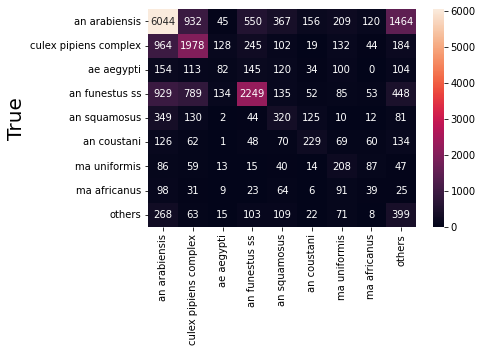

Epoch: 22, Train Loss: 0.08963516, Train F1: 0.96033215, Val Loss: 0.00825941, Val F1: 0.69554062, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 23batch = 0 of 813duraation = 0.09215943415959676
epoch = 23batch = 200 of 813duraation = 5.001248375574748
epoch = 23batch = 400 of 813duraation = 9.922393484910328
epoch = 23batch = 600 of 813duraation = 14.868494315942128
epoch = 23batch = 800 of 813duraation = 19.756934603055317
Saving model to: ../outputs/models/pytorch/model_e23_2022_09_16_23_07_17.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.66      0.64      9018
culex pipiens complex       0.56      0.46      0.50      4157
           ae aegypti       0.19      0.24      0.21       429
       an funestus ss       0.48      0.67      0.56      3422
         an squamosus       0.26      0.35      0.30      1327
          an coustani       0.24      0.32      0.28       657
         ma uniformis       0.38      0.23      0.29       975
         ma africanus       0.19      0.06      0.09       423
               others    

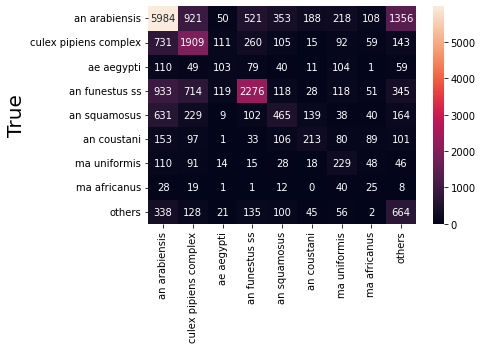

Epoch: 23, Train Loss: 0.10835118, Train F1: 0.95465721, Val Loss: 0.00819920, Val F1: 0.68928534, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 24batch = 0 of 813duraation = 0.09297581116358439
epoch = 24batch = 200 of 813duraation = 4.976138063271841
epoch = 24batch = 400 of 813duraation = 9.919690692424775
epoch = 24batch = 600 of 813duraation = 14.80223085085551
epoch = 24batch = 800 of 813duraation = 19.734152464071908
Saving model to: ../outputs/models/pytorch/model_e24_2022_09_16_23_36_32.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.64      0.60      0.62      9018
culex pipiens complex       0.44      0.53      0.48      4157
           ae aegypti       0.12      0.12      0.12       429
       an funestus ss       0.54      0.60      0.57      3422
         an squamosus       0.30      0.23      0.26      1327
          an coustani       0.23      0.55      0.32       657
         ma uniformis       0.27      0.14      0.19       975
         ma africanus       0.14      0.26      0.18       423
               others     

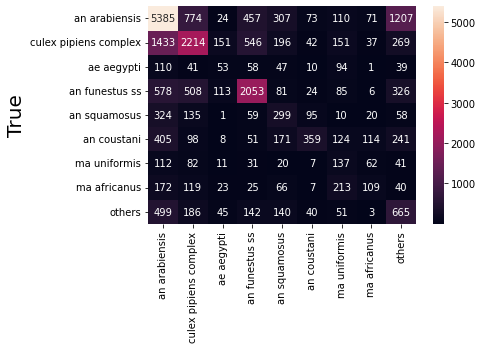

Epoch: 24, Train Loss: 0.07864176, Train F1: 0.96603307, Val Loss: 0.00924845, Val F1: 0.66945333, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 25batch = 0 of 813duraation = 0.09453629652659098
epoch = 25batch = 200 of 813duraation = 4.98631237745285
epoch = 25batch = 400 of 813duraation = 9.90818780263265
epoch = 25batch = 600 of 813duraation = 14.84489187002182
epoch = 25batch = 800 of 813duraation = 19.762180451552073
Saving model to: ../outputs/models/pytorch/model_e25_2022_09_17_00_05_51.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.67      0.64      9018
culex pipiens complex       0.50      0.47      0.49      4157
           ae aegypti       0.12      0.19      0.14       429
       an funestus ss       0.51      0.59      0.55      3422
         an squamosus       0.23      0.26      0.24      1327
          an coustani       0.24      0.34      0.28       657
         ma uniformis       0.35      0.22      0.27       975
         ma africanus       0.10      0.05      0.06       423
               others       

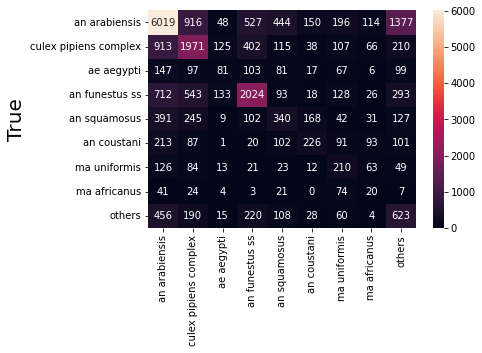

Epoch: 25, Train Loss: 0.08982930, Train F1: 0.96079072, Val Loss: 0.00824121, Val F1: 0.68807954, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 26batch = 0 of 813duraation = 0.09152555068333944
epoch = 26batch = 200 of 813duraation = 5.03128133614858
epoch = 26batch = 400 of 813duraation = 10.022319042682648
epoch = 26batch = 600 of 813duraation = 14.928232010205587
epoch = 26batch = 800 of 813duraation = 19.820577851931255
Saving model to: ../outputs/models/pytorch/model_e26_2022_09_17_00_35_34.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.68      0.64      9018
culex pipiens complex       0.51      0.51      0.51      4157
           ae aegypti       0.14      0.16      0.15       429
       an funestus ss       0.48      0.68      0.56      3422
         an squamosus       0.28      0.25      0.27      1327
          an coustani       0.27      0.32      0.29       657
         ma uniformis       0.40      0.26      0.32       975
         ma africanus       0.13      0.08      0.10       423
               others    

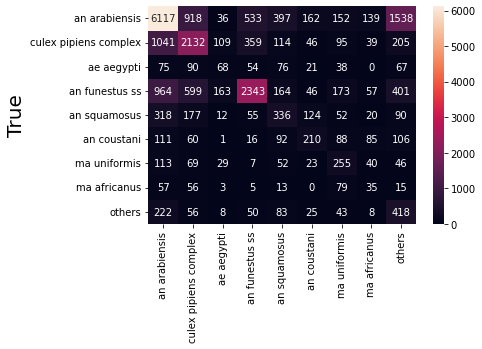

Epoch: 26, Train Loss: 0.08739632, Train F1: 0.96303205, Val Loss: 0.00848252, Val F1: 0.69327426, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 27batch = 0 of 813duraation = 0.10607155561447143
epoch = 27batch = 200 of 813duraation = 5.034440970420837
epoch = 27batch = 400 of 813duraation = 10.203550338745117
epoch = 27batch = 600 of 813duraation = 15.114796566963197
epoch = 27batch = 800 of 813duraation = 20.02210763692856
Saving model to: ../outputs/models/pytorch/model_e27_2022_09_17_01_05_28.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.60      0.64      0.62      9018
culex pipiens complex       0.48      0.48      0.48      4157
           ae aegypti       0.10      0.10      0.10       429
       an funestus ss       0.55      0.53      0.54      3422
         an squamosus       0.27      0.25      0.26      1327
          an coustani       0.24      0.45      0.31       657
         ma uniformis       0.26      0.22      0.24       975
         ma africanus       0.18      0.10      0.13       423
               others    

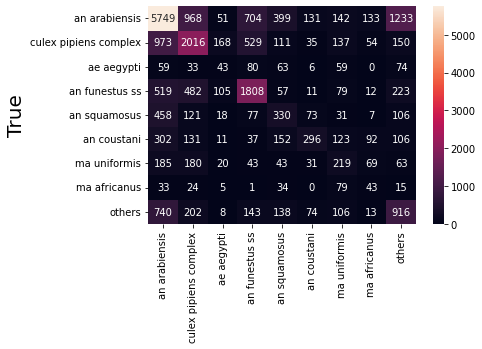

Epoch: 27, Train Loss: 0.08804943, Train F1: 0.96291731, Val Loss: 0.00876191, Val F1: 0.67986644, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 28batch = 0 of 813duraation = 0.09960551261901855
epoch = 28batch = 200 of 813duraation = 5.004210499922435
epoch = 28batch = 400 of 813duraation = 9.93110801378886
epoch = 28batch = 600 of 813duraation = 14.84903260866801
epoch = 28batch = 800 of 813duraation = 19.743973811467487
Saving model to: ../outputs/models/pytorch/model_e28_2022_09_17_01_34_39.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.65      0.64      9018
culex pipiens complex       0.45      0.59      0.51      4157
           ae aegypti       0.16      0.17      0.16       429
       an funestus ss       0.54      0.58      0.56      3422
         an squamosus       0.28      0.22      0.25      1327
          an coustani       0.27      0.38      0.31       657
         ma uniformis       0.35      0.29      0.32       975
         ma africanus       0.16      0.09      0.11       423
               others      

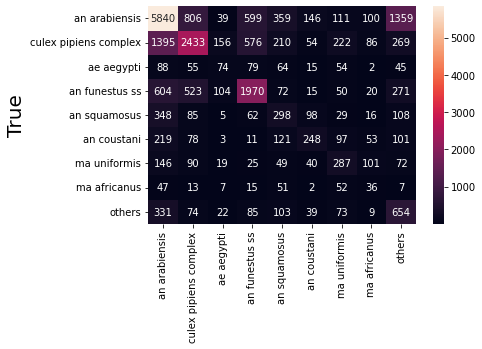

Epoch: 28, Train Loss: 0.07391822, Train F1: 0.96757050, Val Loss: 0.00823283, Val F1: 0.70701552, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 29batch = 0 of 813duraation = 0.09038469394048056
epoch = 29batch = 200 of 813duraation = 5.004596149921417
epoch = 29batch = 400 of 813duraation = 9.932379798094432
epoch = 29batch = 600 of 813duraation = 14.83006340265274
epoch = 29batch = 800 of 813duraation = 19.768573943773905
Saving model to: ../outputs/models/pytorch/model_e29_2022_09_17_02_03_52.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.63      0.62      0.62      9018
culex pipiens complex       0.44      0.54      0.49      4157
           ae aegypti       0.15      0.32      0.21       429
       an funestus ss       0.54      0.54      0.54      3422
         an squamosus       0.25      0.24      0.24      1327
          an coustani       0.29      0.30      0.30       657
         ma uniformis       0.33      0.25      0.28       975
         ma africanus       0.07      0.14      0.10       423
               others     

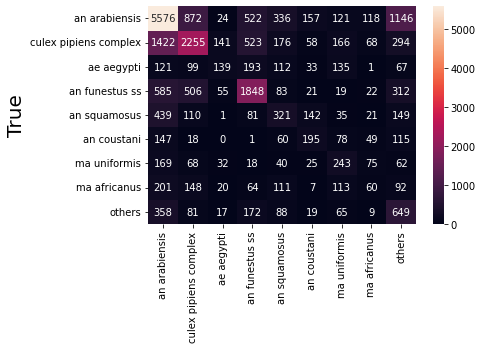

Epoch: 29, Train Loss: 0.08403587, Train F1: 0.96510658, Val Loss: 0.00845316, Val F1: 0.68085446, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 30batch = 0 of 813duraation = 0.0931732455889384
epoch = 30batch = 200 of 813duraation = 5.013855282465617
epoch = 30batch = 400 of 813duraation = 9.924577414989471
epoch = 30batch = 600 of 813duraation = 14.761699608961742
epoch = 30batch = 800 of 813duraation = 19.68087814251582
Saving model to: ../outputs/models/pytorch/model_e30_2022_09_17_02_33_00.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.67      0.64      9018
culex pipiens complex       0.49      0.52      0.50      4157
           ae aegypti       0.14      0.15      0.14       429
       an funestus ss       0.48      0.63      0.54      3422
         an squamosus       0.33      0.26      0.29      1327
          an coustani       0.29      0.30      0.30       657
         ma uniformis       0.37      0.22      0.27       975
         ma africanus       0.17      0.05      0.08       423
               others      

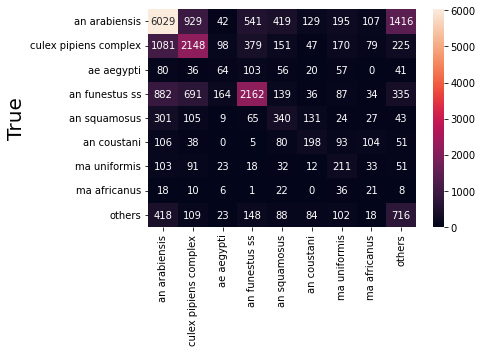

Epoch: 30, Train Loss: 0.07841939, Train F1: 0.96726160, Val Loss: 0.00820136, Val F1: 0.70662644, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 31batch = 0 of 813duraation = 0.10028764406840006
epoch = 31batch = 200 of 813duraation = 4.943107537428538
epoch = 31batch = 400 of 813duraation = 9.873451757431031
epoch = 31batch = 600 of 813duraation = 14.731289068857828
epoch = 31batch = 800 of 813duraation = 19.68214058081309
Saving model to: ../outputs/models/pytorch/model_e31_2022_09_17_03_02_09.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.63      0.63      0.63      9018
culex pipiens complex       0.53      0.50      0.51      4157
           ae aegypti       0.15      0.17      0.16       429
       an funestus ss       0.49      0.67      0.57      3422
         an squamosus       0.24      0.28      0.26      1327
          an coustani       0.26      0.41      0.32       657
         ma uniformis       0.33      0.22      0.26       975
         ma africanus       0.24      0.19      0.21       423
               others     

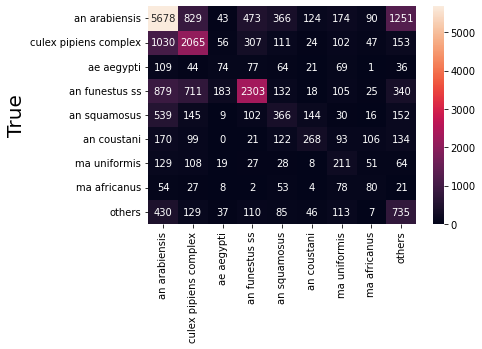

Epoch: 31, Train Loss: 0.07317068, Train F1: 0.96848668, Val Loss: 0.00862018, Val F1: 0.69494366, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 32batch = 0 of 813duraation = 0.09649754762649536
epoch = 32batch = 200 of 813duraation = 5.026705916722616
epoch = 32batch = 400 of 813duraation = 9.970153530438742
epoch = 32batch = 600 of 813duraation = 14.864226118723552
epoch = 32batch = 800 of 813duraation = 19.789609865347543
Saving model to: ../outputs/models/pytorch/model_e32_2022_09_17_03_31_35.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.61      0.61      9018
culex pipiens complex       0.50      0.51      0.51      4157
           ae aegypti       0.11      0.11      0.11       429
       an funestus ss       0.50      0.62      0.55      3422
         an squamosus       0.26      0.28      0.27      1327
          an coustani       0.31      0.40      0.35       657
         ma uniformis       0.30      0.28      0.29       975
         ma africanus       0.18      0.08      0.11       423
               others    

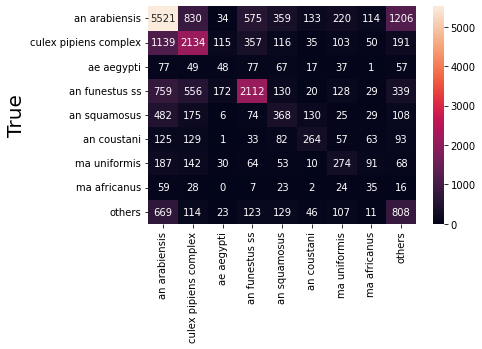

Epoch: 32, Train Loss: 0.06950402, Train F1: 0.97045769, Val Loss: 0.00846753, Val F1: 0.69645100, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 33batch = 0 of 813duraation = 0.09405288298924765
epoch = 33batch = 200 of 813duraation = 5.021990485986074
epoch = 33batch = 400 of 813duraation = 9.967292773723603
epoch = 33batch = 600 of 813duraation = 14.858865662415822
epoch = 33batch = 800 of 813duraation = 19.773607182502747
Saving model to: ../outputs/models/pytorch/model_e33_2022_09_17_04_01_06.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.63      0.64      0.63      9018
culex pipiens complex       0.46      0.57      0.51      4157
           ae aegypti       0.13      0.16      0.15       429
       an funestus ss       0.52      0.56      0.54      3422
         an squamosus       0.27      0.25      0.26      1327
          an coustani       0.39      0.36      0.37       657
         ma uniformis       0.34      0.16      0.22       975
         ma africanus       0.10      0.08      0.09       423
               others    

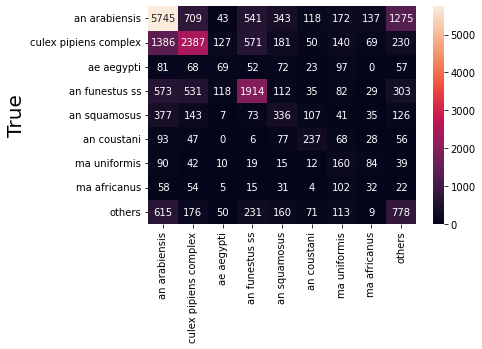

Epoch: 33, Train Loss: 0.08064150, Train F1: 0.96686463, Val Loss: 0.00857471, Val F1: 0.68297750, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 34batch = 0 of 813duraation = 0.0974825898806254
epoch = 34batch = 200 of 813duraation = 5.028068176905314
epoch = 34batch = 400 of 813duraation = 9.951005105177561
epoch = 34batch = 600 of 813duraation = 14.861235539118448
epoch = 34batch = 800 of 813duraation = 19.8127982934316
Saving model to: ../outputs/models/pytorch/model_e34_2022_09_17_04_30_47.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.63      0.63      0.63      9018
culex pipiens complex       0.45      0.54      0.49      4157
           ae aegypti       0.20      0.21      0.20       429
       an funestus ss       0.54      0.48      0.51      3422
         an squamosus       0.26      0.23      0.25      1327
          an coustani       0.32      0.39      0.35       657
         ma uniformis       0.31      0.29      0.30       975
         ma africanus       0.07      0.05      0.06       423
               others       

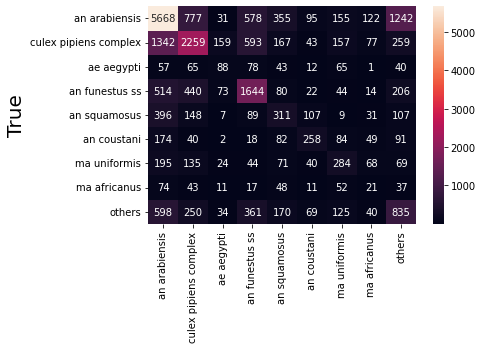

Epoch: 34, Train Loss: 0.05996410, Train F1: 0.97326951, Val Loss: 0.00936247, Val F1: 0.67837668, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 35batch = 0 of 813duraation = 0.09979701439539591
epoch = 35batch = 200 of 813duraation = 5.031493600209554
epoch = 35batch = 400 of 813duraation = 9.991191625595093
epoch = 35batch = 600 of 813duraation = 14.888714154561361
epoch = 35batch = 800 of 813duraation = 19.80550803343455
Saving model to: ../outputs/models/pytorch/model_e35_2022_09_17_05_00_34.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.64      0.62      9018
culex pipiens complex       0.46      0.56      0.50      4157
           ae aegypti       0.16      0.20      0.18       429
       an funestus ss       0.52      0.56      0.54      3422
         an squamosus       0.25      0.26      0.25      1327
          an coustani       0.33      0.29      0.31       657
         ma uniformis       0.28      0.23      0.26       975
         ma africanus       0.09      0.09      0.09       423
               others     

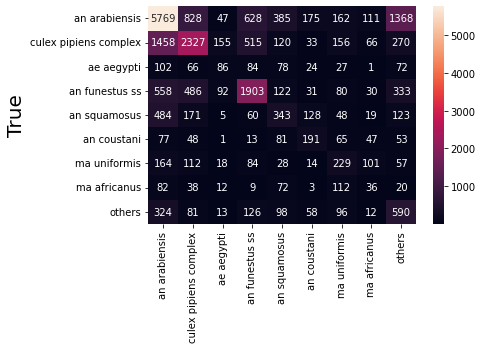

Epoch: 35, Train Loss: 0.06614157, Train F1: 0.97113464, Val Loss: 0.00857921, Val F1: 0.68757521, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 36batch = 0 of 813duraation = 0.08509636720021566


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Saving model to: ../outputs/models/pytorch/model_e37_2022_09_17_06_00_39.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.64      0.59      0.62      9018
culex pipiens complex       0.48      0.48      0.48      4157
           ae aegypti       0.11      0.14      0.12       429
       an funestus ss       0.45      0.66      0.54      3422
         an squamosus       0.34      0.24      0.28      1327
          an coustani       0.29      0.52      0.37       657
         ma uniformis       0.37      0.18      0.24       975
         ma africanus       0.12      0.15      0.13       423
               others       0.34      0.26      0.29      2886

             accuracy                           0.49     23294
            macro avg       0.35      0.36      0.34     23294
         weighted avg       0.49      0.49      0.48     23294



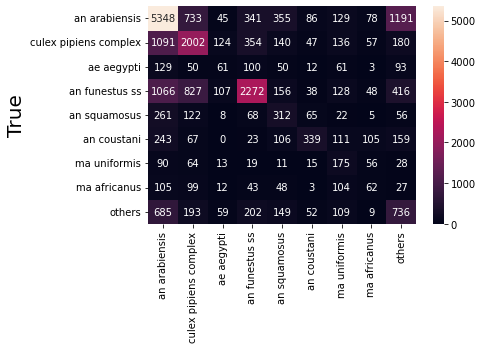

Epoch: 37, Train Loss: 0.06750326, Train F1: 0.97109186, Val Loss: 0.00896328, Val F1: 0.68602289, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 38batch = 0 of 813duraation = 0.0989593784014384
epoch = 38batch = 200 of 813duraation = 5.051936384042104
epoch = 38batch = 400 of 813duraation = 10.167226998011271
epoch = 38batch = 600 of 813duraation = 15.113240242004395
epoch = 38batch = 800 of 813duraation = 20.04654109875361
Saving model to: ../outputs/models/pytorch/model_e38_2022_09_17_06_31_23.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.63      0.65      0.64      9018
culex pipiens complex       0.50      0.56      0.53      4157
           ae aegypti       0.20      0.19      0.19       429
       an funestus ss       0.48      0.62      0.54      3422
         an squamosus       0.31      0.26      0.28      1327
          an coustani       0.30      0.37      0.33       657
         ma uniformis       0.29      0.25      0.27       975
         ma africanus       0.07      0.04      0.05       423
               others     

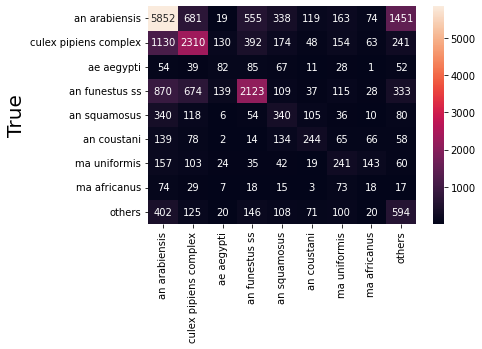

Epoch: 38, Train Loss: 0.06540518, Train F1: 0.97283756, Val Loss: 0.00869315, Val F1: 0.69914479, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 39batch = 0 of 813duraation = 0.1346030791600545


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch = 41batch = 200 of 813duraation = 5.157180273532868
epoch = 41batch = 400 of 813duraation = 10.52623610496521
epoch = 41batch = 600 of 813duraation = 15.48285696109136
epoch = 41batch = 800 of 813duraation = 20.55108509461085
Saving model to: ../outputs/models/pytorch/model_e41_2022_09_17_08_05_16.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.64      0.61      0.62      9018
culex pipiens complex       0.47      0.55      0.51      4157
           ae aegypti       0.19      0.26      0.22       429
       an funestus ss       0.48      0.61      0.54      3422
         an squamosus       0.30      0.22      0.25      1327
          an coustani       0.35      0.38      0.37       657
         ma uniformis       0.29      0.29      0.29       975
         ma africanus       0.05      0.03      0.03       423
               others       0.41      0.30      0.34      2886

             accuracy

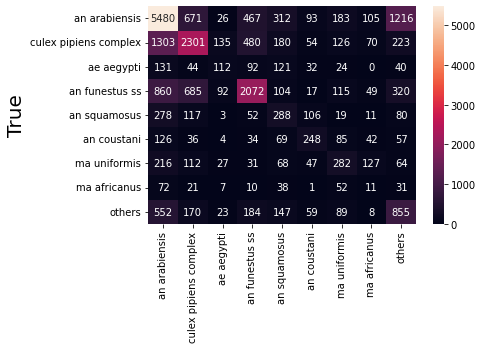

Epoch: 41, Train Loss: 0.06508223, Train F1: 0.97250807, Val Loss: 0.00881661, Val F1: 0.67941925, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 42batch = 0 of 813duraation = 0.14424360593159993


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch = 44batch = 200 of 813duraation = 4.960018360614777
epoch = 44batch = 400 of 813duraation = 10.380585332711538
epoch = 44batch = 600 of 813duraation = 15.393524078528086
epoch = 44batch = 800 of 813duraation = 20.379206172625224
Saving model to: ../outputs/models/pytorch/model_e44_2022_09_17_09_38_52.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.66      0.64      9018
culex pipiens complex       0.49      0.51      0.50      4157
           ae aegypti       0.16      0.40      0.23       429
       an funestus ss       0.49      0.56      0.52      3422
         an squamosus       0.28      0.20      0.23      1327
          an coustani       0.32      0.29      0.30       657
         ma uniformis       0.37      0.23      0.29       975
         ma africanus       0.08      0.06      0.07       423
               others       0.35      0.22      0.27      2886

             accur

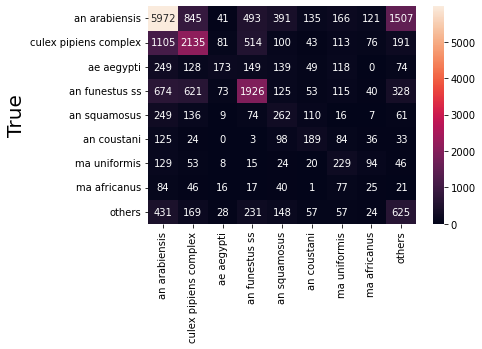

Epoch: 44, Train Loss: 0.05162790, Train F1: 0.97701879, Val Loss: 0.00961828, Val F1: 0.68269110, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 45batch = 0 of 813duraation = 0.1119123101234436
epoch = 45batch = 200 of 813duraation = 5.0561670104662575


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch = 47batch = 400 of 813duraation = 10.583911577860514
epoch = 47batch = 600 of 813duraation = 15.57797858317693
epoch = 47batch = 800 of 813duraation = 20.577636285622916
Saving model to: ../outputs/models/pytorch/model_e47_2022_09_17_11_13_18.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.67      0.64      9018
culex pipiens complex       0.51      0.48      0.50      4157
           ae aegypti       0.19      0.32      0.24       429
       an funestus ss       0.51      0.57      0.54      3422
         an squamosus       0.22      0.24      0.23      1327
          an coustani       0.33      0.28      0.30       657
         ma uniformis       0.38      0.24      0.30       975
         ma africanus       0.06      0.05      0.05       423
               others       0.38      0.24      0.29      2886

             accuracy                           0.50     23294
            ma

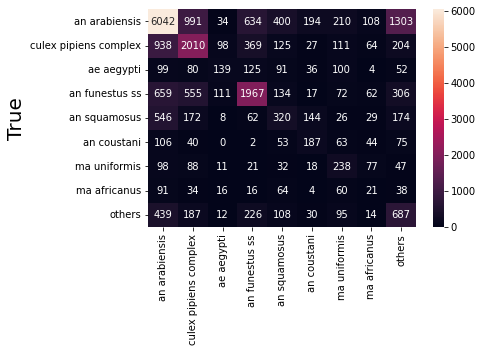

Epoch: 47, Train Loss: 0.06181954, Train F1: 0.97547438, Val Loss: 0.00913165, Val F1: 0.68952710, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 48batch = 0 of 813duraation = 0.07557786305745443
epoch = 48batch = 200 of 813duraation = 5.1165143291155495


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch = 50batch = 800 of 813duraation = 20.70689974228541
Saving model to: ../outputs/models/pytorch/model_e50_2022_09_17_12_47_32.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.58      0.75      0.65      9018
culex pipiens complex       0.54      0.50      0.52      4157
           ae aegypti       0.18      0.26      0.21       429
       an funestus ss       0.51      0.56      0.54      3422
         an squamosus       0.37      0.20      0.26      1327
          an coustani       0.35      0.28      0.31       657
         ma uniformis       0.40      0.23      0.29       975
         ma africanus       0.12      0.05      0.07       423
               others       0.41      0.21      0.27      2886

             accuracy                           0.52     23294
            macro avg       0.38      0.34      0.35     23294
         weighted avg       0.50      0.52      0.50     23294



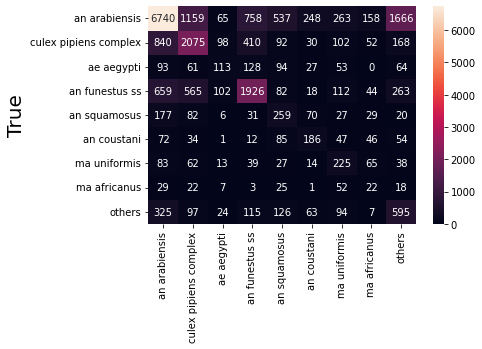

Epoch: 50, Train Loss: 0.04461272, Train F1: 0.98017126, Val Loss: 0.00968587, Val F1: 0.69586151, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 51batch = 0 of 813duraation = 0.0892890731493632
epoch = 51batch = 200 of 813duraation = 5.217308616638183
epoch = 51batch = 400 of 813duraation = 10.219916709264119
epoch = 51batch = 600 of 813duraation = 15.123929818471273
epoch = 51batch = 800 of 813duraation = 20.05496204694112
Saving model to: ../outputs/models/pytorch/model_e51_2022_09_17_13_18_02.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.60      0.68      0.64      9018
culex pipiens complex       0.51      0.54      0.53      4157
           ae aegypti       0.19      0.22      0.21       429
       an funestus ss       0.49      0.57      0.53      3422
         an squamosus       0.33      0.18      0.23      1327
          an coustani       0.32      0.39      0.35       657
         ma uniformis       0.40      0.22      0.28       975
         ma africanus       0.14      0.11      0.12       423
               others     

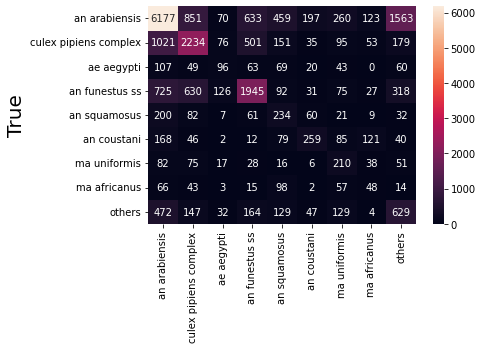

Epoch: 51, Train Loss: 0.05507462, Train F1: 0.97716875, Val Loss: 0.00946772, Val F1: 0.68539384, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 52batch = 0 of 813duraation = 0.08984366655349732


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch = 53batch = 800 of 813duraation = 21.153511655330657
Saving model to: ../outputs/models/pytorch/model_e53_2022_09_17_14_20_59.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.69      0.65      9018
culex pipiens complex       0.49      0.53      0.51      4157
           ae aegypti       0.22      0.21      0.22       429
       an funestus ss       0.50      0.61      0.55      3422
         an squamosus       0.32      0.20      0.25      1327
          an coustani       0.34      0.41      0.37       657
         ma uniformis       0.36      0.28      0.31       975
         ma africanus       0.07      0.04      0.05       423
               others       0.38      0.21      0.27      2886

             accuracy                           0.52     23294
            macro avg       0.37      0.35      0.35     23294
         weighted avg       0.50      0.52      0.50     23294



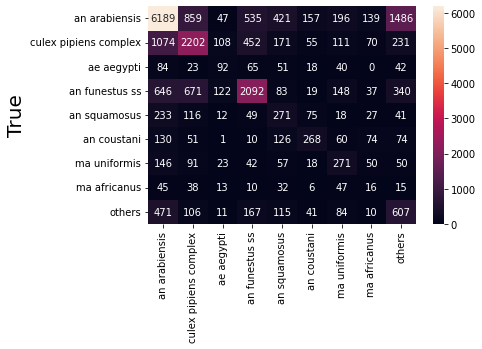

Epoch: 53, Train Loss: 0.04992530, Train F1: 0.97957302, Val Loss: 0.00933791, Val F1: 0.70690216, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 54batch = 0 of 813duraation = 0.13611770470937093
epoch = 54batch = 200 of 813duraation = 5.596319488684336
epoch = 54batch = 400 of 813duraation = 10.898393917083741
epoch = 54batch = 600 of 813duraation = 15.812792853514354
epoch = 54batch = 800 of 813duraation = 21.063154820601145
Saving model to: ../outputs/models/pytorch/model_e54_2022_09_17_14_53_09.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.69      0.65      9018
culex pipiens complex       0.50      0.55      0.52      4157
           ae aegypti       0.15      0.21      0.17       429
       an funestus ss       0.52      0.57      0.54      3422
         an squamosus       0.30      0.15      0.20      1327
          an coustani       0.25      0.40      0.31       657
         ma uniformis       0.35      0.25      0.29       975
         ma africanus       0.05      0.02      0.03       423
               others   

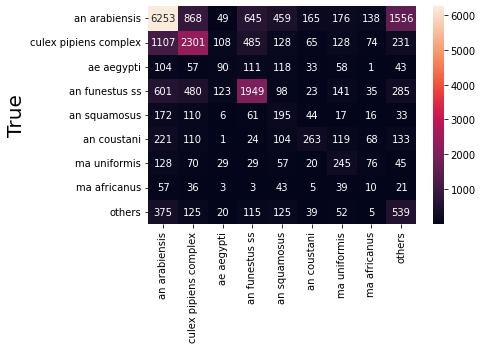

Epoch: 54, Train Loss: 0.04109894, Train F1: 0.98204535, Val Loss: 0.00945316, Val F1: 0.69390013, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 55batch = 0 of 813duraation = 0.16616489092508951


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch = 57batch = 200 of 813duraation = 5.0282319267590845
epoch = 57batch = 400 of 813duraation = 9.98085036277771
epoch = 57batch = 600 of 813duraation = 14.889816685517628
epoch = 57batch = 800 of 813duraation = 19.83811771074931
Saving model to: ../outputs/models/pytorch/model_e57_2022_09_17_16_28_15.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.68      0.64      9018
culex pipiens complex       0.51      0.50      0.51      4157
           ae aegypti       0.11      0.17      0.14       429
       an funestus ss       0.46      0.65      0.54      3422
         an squamosus       0.27      0.18      0.21      1327
          an coustani       0.28      0.29      0.28       657
         ma uniformis       0.35      0.29      0.32       975
         ma africanus       0.16      0.11      0.13       423
               others       0.45      0.16      0.24      2886

             accurac

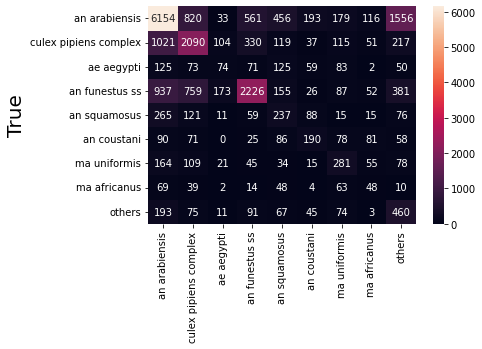

Epoch: 57, Train Loss: 0.04146821, Train F1: 0.98236938, Val Loss: 0.00989215, Val F1: 0.69767676, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 58batch = 0 of 813duraation = 0.08955892324447631
epoch = 58batch = 200 of 813duraation = 5.009466715653738


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch = 60batch = 200 of 813duraation = 5.344441850980123
epoch = 60batch = 400 of 813duraation = 10.662338848908743
epoch = 60batch = 600 of 813duraation = 15.711079343159993
epoch = 60batch = 800 of 813duraation = 20.69823509454727
Saving model to: ../outputs/models/pytorch/model_e60_2022_09_17_18_05_14.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.67      0.64      9018
culex pipiens complex       0.49      0.50      0.49      4157
           ae aegypti       0.21      0.17      0.19       429
       an funestus ss       0.44      0.64      0.52      3422
         an squamosus       0.29      0.21      0.24      1327
          an coustani       0.35      0.32      0.33       657
         ma uniformis       0.38      0.30      0.34       975
         ma africanus       0.11      0.03      0.04       423
               others       0.44      0.23      0.30      2886

             accura

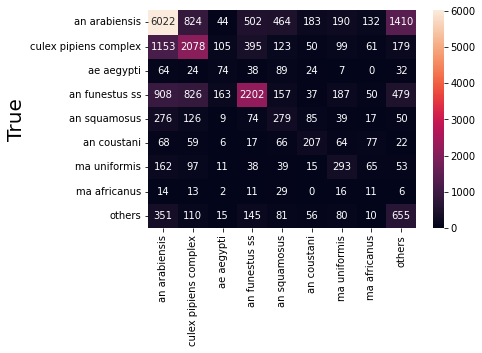

Epoch: 60, Train Loss: 0.04271946, Train F1: 0.98180564, Val Loss: 0.01004425, Val F1: 0.69292991, overrun_counter 0


  0%|          | 0/813 [00:00<?, ?it/s]

epoch = 61batch = 0 of 813duraation = 0.10684475898742676
epoch = 61batch = 200 of 813duraation = 5.089446397622426
epoch = 61batch = 400 of 813duraation = 10.592497714360555
epoch = 61batch = 600 of 813duraation = 15.687626624107361


In [ ]:
model =Model('convnext_small',224)
#train_loader, val_loader, model = None,  classes = classes,n_channels = 1
model, lr_log = train_model(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )

In [ ]:
prediction  = [2.0, 3.0, 8.0, 2.0, 8.0, 8.0, 4.0, 0.0, 7.0, 8.0, 8.0, 2.0, 8.0, 0.0, 1.0, 3.0, 4.0, 8.0, 5.0, 8.0, 2.0, 2.0, 2.0, 0.0, 5.0, 5.0, 3.0, 8.0, 4.0, 1.0, 2.0, 5.0, 6.0, 1.0, 8.0, 0.0, 2.0, 4.0, 6.0, 8.0, 7.0, 0.0, 7.0, 0.0, 8.0, 5.0, 8.0, 2.0, 0.0, 0.0, 4.0, 7.0, 5.0, 4.0, 1.0, 2.0, 4.0, 1.0, 6.0, 4.0, 3.0, 7.0, 8.0, 8.0, 0.0, 6.0, 7.0, 1.0, 6.0, 5.0, 7.0, 0.0, 5.0, 0.0, 0.0, 2.0, 1.0, 5.0, 8.0, 1.0, 5.0, 7.0, 5.0, 7.0, 3.0, 6.0, 6.0, 6.0, 2.0, 6.0, 2.0, 6.0, 6.0, 3.0, 6.0, 6.0, 0.0, 4.0, 6.0, 6.0, 0.0, 8.0, 7.0, 1.0, 4.0, 1.0, 3.0, 0.0, 8.0, 6.0, 5.0, 7.0, 7.0, 3.0, 2.0, 0.0, 4.0, 3.0, 4.0, 2.0, 4.0, 2.0, 7.0, 3.0, 1.0, 3.0, 6.0, 5.0, 5.0, 2.0, 0.0, 2.0, 0.0, 6.0, 3.0, 0.0, 3.0, 4.0, 8.0, 6.0, 4.0, 6.0, 0.0, 4.0, 5.0, 2.0, 6.0, 1.0, 1.0, 5.0, 4.0, 6.0, 5.0, 8.0, 0.0, 3.0, 4.0, 4.0, 4.0, 8.0, 8.0, 5.0, 5.0, 0.0, 1.0, 3.0, 3.0, 7.0, 7.0, 1.0, 5.0, 7.0, 6.0, 5.0, 8.0, 3.0, 8.0, 5.0, 2.0, 3.0, 7.0, 3.0, 7.0, 8.0, 4.0, 2.0, 0.0, 6.0, 8.0, 1.0, 3.0, 6.0, 2.0, 2.0, 7.0, 7.0, 2.0, 0.0, 4.0, 8.0]
Label   = [3.0, 5.0, 0.0, 0.0, 2.0, 0.0, 1.0, 3.0, 4.0, 7.0, 1.0, 3.0, 2.0, 1.0, 4.0, 1.0, 3.0, 8.0, 8.0, 8.0, 3.0, 4.0, 7.0, 6.0, 4.0, 1.0, 3.0, 0.0, 7.0, 7.0, 3.0, 1.0, 4.0, 3.0, 5.0, 3.0, 4.0, 2.0, 8.0, 8.0, 7.0, 4.0, 7.0, 2.0, 6.0, 1.0, 8.0, 4.0, 8.0, 0.0, 1.0, 4.0, 2.0, 2.0, 0.0, 8.0, 1.0, 7.0, 4.0, 1.0, 2.0, 1.0, 2.0, 3.0, 6.0, 3.0, 6.0, 5.0, 4.0, 0.0, 5.0, 8.0, 5.0, 7.0, 1.0, 1.0, 6.0, 8.0, 6.0, 6.0, 4.0, 6.0, 6.0, 6.0, 8.0, 4.0, 5.0, 8.0, 0.0, 7.0, 4.0, 1.0, 6.0, 1.0, 5.0, 5.0, 5.0, 3.0, 8.0, 7.0, 8.0, 1.0, 2.0, 7.0, 2.0, 0.0, 4.0, 3.0, 2.0, 5.0, 1.0, 1.0, 2.0, 3.0, 0.0, 4.0, 7.0, 5.0, 2.0, 2.0, 6.0, 7.0, 2.0, 2.0, 6.0, 4.0, 2.0, 5.0, 8.0, 3.0, 6.0, 1.0, 1.0, 6.0, 5.0, 0.0, 2.0, 5.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 4.0, 3.0, 0.0, 6.0, 3.0, 7.0, 1.0, 2.0, 7.0, 3.0, 6.0, 1.0, 3.0, 8.0, 3.0, 6.0, 1.0, 4.0, 4.0, 6.0, 2.0, 5.0, 3.0, 0.0, 5.0, 7.0, 3.0, 5.0, 6.0, 4.0, 7.0, 1.0, 1.0, 6.0, 1.0, 4.0, 5.0, 8.0, 4.0, 6.0, 4.0, 5.0, 1.0, 6.0, 0.0, 3.0, 3.0, 3.0, 4.0, 7.0, 5.0, 2.0, 6.0, 2.0, 4.0]
print(classification_report(np.array(Label), np.array(prediction), target_names= classes))
from sklearn.metrics import confusion_matrix
classes
cm = confusion_matrix(prediction, Label ,labels= range(0,9))
print(cm)
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
ax.xaxis.set_ticklabels(classes, fontsize = 10)
ax.xaxis.tick_bottom()
plt.xticks(rotation=90)
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(classes, fontsize = 10)
plt.yticks(rotation=0)

In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))